In [1]:
from dataclasses import dataclass
import sys

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, CenterCrop, Resize, Normalize
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from nuy_v2_loader import NYUV2Dataset
from stepper import Stepper, MultiTermLossStepper
from summary_writer import SummaryWriter, WandBSummaryWritter
from metrics import (
  absolute_relative_mean_error,
  root_mean_squared_error,
  average_absolute_log_error,
  threshold_acc
)
from loss import nyuv2_loss_fn, sil_loss, grad_l1_loss, nyuv2_multiterm_loss_fn, nyuv2_multiterm_loss_fn_vit
from models.res_refinet import Resnet101RefineNet
from models.compose_net import ComposeNet
from multiterm_optim import MultiTermAdam

In [2]:
%run -i 'constants.py'

In [3]:
BATCH_SIZE = 24
MAX_DATA_LENGHT = None

EPOCHS = 16
LR = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
np.random.seed(SEED)

In [5]:
# if not os.path.exists('datasets/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [6]:
NYU_V2_IMG_DIMENSION = (448, 608)

transforms = Compose([
  ToTensor(), CenterCrop(NYU_V2_IMG_DIMENSION), Resize(size=INPUT_SIZE),
])
rgb_t = Compose([
  transforms,
  Normalize(mean=RGB.mean, std=RGB.std),
  v2.RandomChannelPermutation(),
])

train_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'train', download=True, max_lenght=MAX_DATA_LENGHT)
test_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'test', download=True, max_lenght=MAX_DATA_LENGHT)

Failed to load tar file
Finished loading dataset
Failed to load tar file
Finished loading dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


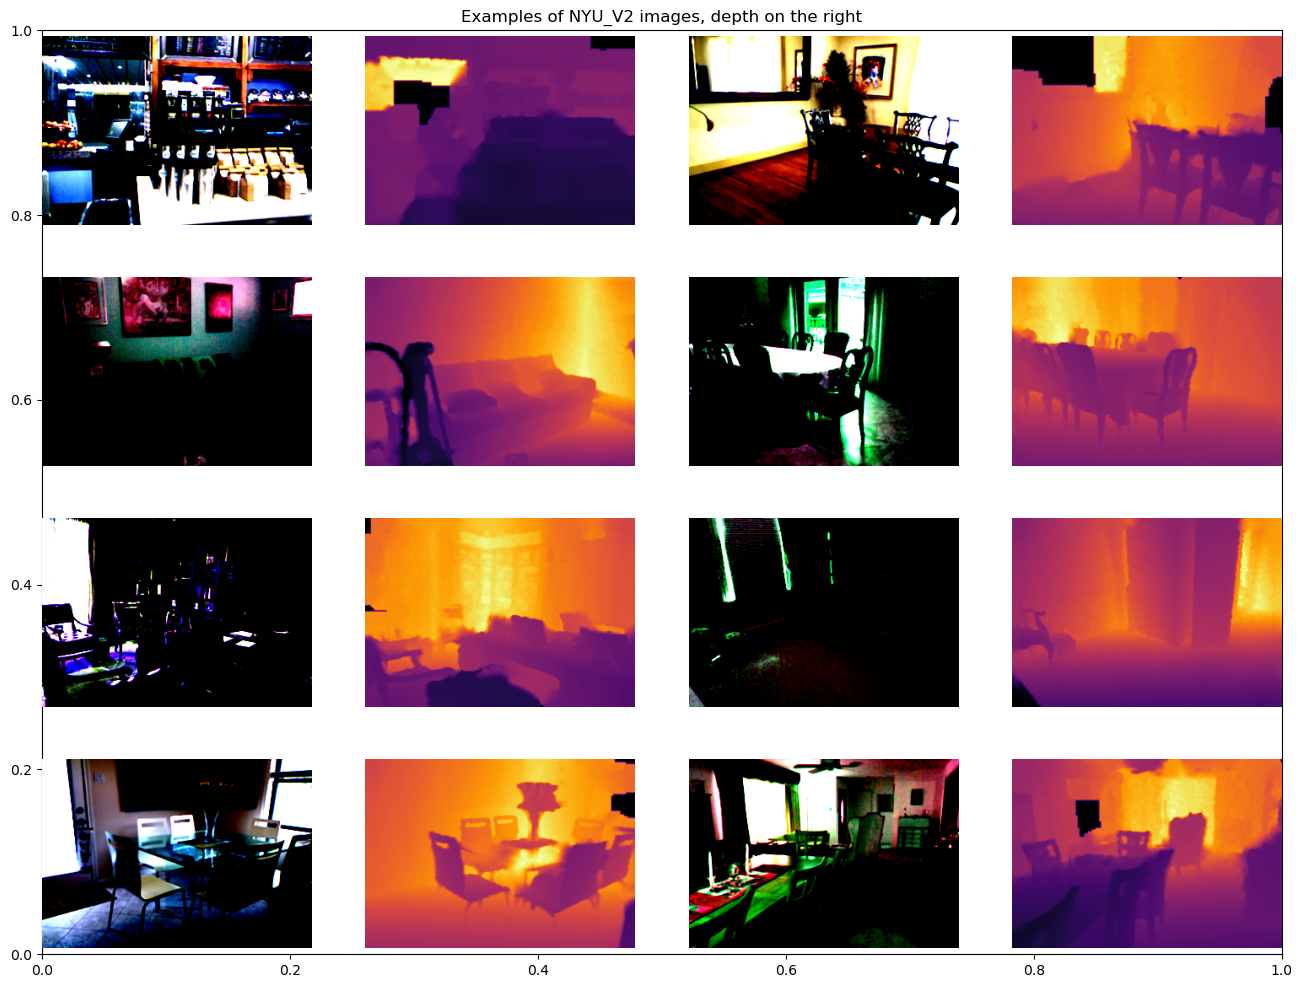

In [7]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [8]:
summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ComposeNet(inputsize=INPUT_SIZE, decoder_channels=256, vit_channels_in=128, classes=128)
optim = AdamW(model.parameters(), lr=LR)
# lr_scheduler = ReduceLROnPlateau(optim, factor=0.1, patience=2, threshold=2e-3)
lr_scheduler = OneCycleLR(
  optim, 
  LR, 
  epochs=EPOCHS, 
  steps_per_epoch=len(train_loader),
  cycle_momentum=True,
  div_factor=20,
  final_div_factor=1e2
)

stepper = Stepper(model, optim=optim, loss_fn=nyuv2_loss_fn, summary_writter=summary_writer)
stepper.set_loaders(train_loader, val_loader)
stepper.set_lr_schedulers(lr_scheduler, over_batch=True)
stepper.to(device)

summary_writer.register(
  project='pure_depth',
  config={
    'architecture': repr(model),
    'optim': 'AdamW',
    'device': device,
    'batch_size': BATCH_SIZE,
    'loss_fn': stepper.loss_fn.__doc__
  }
)

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: percalee. Use `wandb login --relogin` to force relogin


In [9]:
# summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# resnet101_refinet = Resnet101RefineNet()
# optim = MultiTermAdam(resnet101_refinet.parameters(), lr=1e-4, betas=(0.8, 0.98, 0.7))
# stepper = MultiTermLossStepper(resnet101_refinet, optim=optim, loss_fn=nyuv2_multiterm_loss_fn, summary_writter=summary_writer)
# stepper.set_loaders(train_loader, val_loader)
# stepper.to(device)

# summary_writer.register(
#   project='pure_depth',
#   config={
#     'architecture': 'Resnet101_Refinet',
#     'optim': 'MultiTermAdam',
#     'device': device,
#     'batch_size': BATCH_SIZE,
#     'loss_fn': stepper.loss_fn.__doc__
#   }
# )

In [ ]:
# torch.autograd.set_detect_anomaly(True)
stepper.train(n_epochs=EPOCHS)
stepper.save_checkpoint(file_name=f'artifacts/{summary_writer.name}')

validation step: 100%|██████████| 28/28 [00:34<00:00,  1.24s/batch, loss=0.366]


{'train_loss': 0.366099154278899, 'val_loss': 0.27348559722304344, 'epoch': 0, 'lr': 1.4817704950248963e-05}


train step:  14%|█▎        | 271/1983 [09:48<1:01:54,  2.17s/batch, loss=0.303]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

validation step: 100%|██████████| 28/28 [00:33<00:00,  1.20s/batch, loss=0.263]


{'train_loss': 0.26495837322912974, 'val_loss': 0.24675629660487175, 'epoch': 2, 'lr': 7.068651623418902e-05}


train step:  42%|████▏     | 827/1983 [29:40<41:14,  2.14s/batch, loss=0.257]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

validation step: 100%|██████████| 28/28 [00:34<00:00,  1.22s/batch, loss=0.204]


{'train_loss': 0.24006660717698702, 'val_loss': 0.23798433531607902, 'epoch': 4, 'lr': 9.992098321573369e-05}


validation step: 100%|██████████| 28/28 [00:33<00:00,  1.21s/batch, loss=0.345]


{'train_loss': 0.23112442738560193, 'val_loss': 0.2395743727684021, 'epoch': 5, 'lr': 9.719323419629684e-05}


validation step: 100%|██████████| 28/28 [00:34<00:00,  1.24s/batch, loss=0.252]


{'train_loss': 0.22376666428071348, 'val_loss': 0.23778663575649261, 'epoch': 6, 'lr': 9.077856335383597e-05}


validation step: 100%|██████████| 28/28 [00:34<00:00,  1.24s/batch, loss=0.261]


{'train_loss': 0.2179561843489735, 'val_loss': 0.2373747570174081, 'epoch': 7, 'lr': 8.117837571907918e-05}


train step:  11%|█         | 211/1983 [07:40<1:03:23,  2.15s/batch, loss=0.236]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

validation step: 100%|██████████| 28/28 [00:34<00:00,  1.24s/batch, loss=0.231]


{'train_loss': 0.2082794541835905, 'val_loss': 0.2341656663588115, 'epoch': 9, 'lr': 5.561340002169355e-05}


train step:  70%|███████   | 1398/1983 [50:57<21:07,  2.17s/batch, loss=0.194] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

validation step: 100%|██████████| 28/28 [00:34<00:00,  1.22s/batch, loss=0.191]


{'train_loss': 0.19792424074354883, 'val_loss': 0.2311067320406437, 'epoch': 12, 'lr': 1.671905910752882e-05}


train step:  58%|█████▊    | 1143/1983 [41:06<30:22,  2.17s/batch, loss=0.177] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

train step:  50%|█████     | 996/1983 [35:42<35:20,  2.15s/batch, loss=0.176]

In [ ]:
# stepper.load_checkpoint('artifacts/vit_s')

In [ ]:
# Just sanity check
x, y = train_dataset[150]
stepper.model.eval()
pred = stepper.model(x.unsqueeze(0).to(device))

vmax = y.max()
plt.figure(figsize=(8, 6))
ax0 = plt.subplot(1, 2, 1)
show = ax0.imshow(
  np.transpose(pred[0].detach().cpu().numpy(), (1, 2, 0)),
  cmap='inferno'
)
plt.colorbar(show, ax=ax0)
ax1 = plt.subplot(1, 2, 2)
show = ax1.imshow(
  np.transpose(y.detach().numpy(), (1, 2, 0)), 
  cmap='inferno', 
  vmin=0
)
plt.colorbar(show, ax=ax1)

In [ ]:
def evaluate_metrics(model: nn.Module, data_loader: DataLoader, summary_writer: SummaryWriter):
  running_metrics: np.array = None
  
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)

        metrics = np.array((
          absolute_relative_mean_error(pred, y_batch).item(),
          root_mean_squared_error(pred, y_batch).item(),
          average_absolute_log_error(pred, y_batch).item(),
          *(
            metric.item() 
            for metric 
            in threshold_acc(pred, y_batch)
          )
        )).reshape(1, -1)
        
        if running_metrics is None:
          running_metrics = metrics
        else:
          running_metrics = np.vstack((running_metrics, metrics))
  
  mean_metrics = np.mean(running_metrics, axis=0)
  summary_writer.track_object({
    'evaluation_metrics': {
      'absolute_relative_mean_error': mean_metrics[0],
      'root_mean_squared_error': mean_metrics[1],
      'average_absolute_log_error': mean_metrics[2],
      'threshold_accuracy_delta_1': mean_metrics[3],
      'threshold_accuracy_delta_2': mean_metrics[4],
      'threshold_accuracy_delta_3': mean_metrics[5]
    }
  })

evaluate_metrics(stepper.model, val_loader, summary_writer)

In [ ]:
summary_writer.finalize()